<a href="https://colab.research.google.com/github/anthonybaker/colabnotebooks/blob/main/AnthonyB_image2pointcloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Apr 26 06:09:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install plotly -q

In [3]:
!git clone https://github.com/openai/point-e

Cloning into 'point-e'...
remote: Enumerating objects: 57, done.
remote: Total 57 (delta 0), reused 0 (delta 0), pack-reused 57
Unpacking objects: 100% (57/57), 1.56 MiB | 3.52 MiB/s, done.


In [4]:
%cd point-e

/content/point-e


In [5]:
!pip install -e . -q

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.2 MB/s eta 0:00:00


# **Imports**

In [6]:
from PIL import Image
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

# **Models**

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|████████████████████████████████████████| 890M/890M [00:06<00:00, 140MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [8]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [137]:
from google.colab import files
uploaded = files.upload()

Saving Anthony_art_photogrphy_smooth_oval_organic_structure_designed_b_b995b84a-6e06-4d39-84c3-c55993cbe159.png to Anthony_art_photogrphy_smooth_oval_organic_structure_designed_b_b995b84a-6e06-4d39-84c3-c55993cbe159.png


In [138]:
# Load an image to condition on.
img = Image.open('Anthony_art_photogrphy_smooth_oval_organic_structure_designed_b_b995b84a-6e06-4d39-84c3-c55993cbe159.png')

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x

0it [00:00, ?it/s]

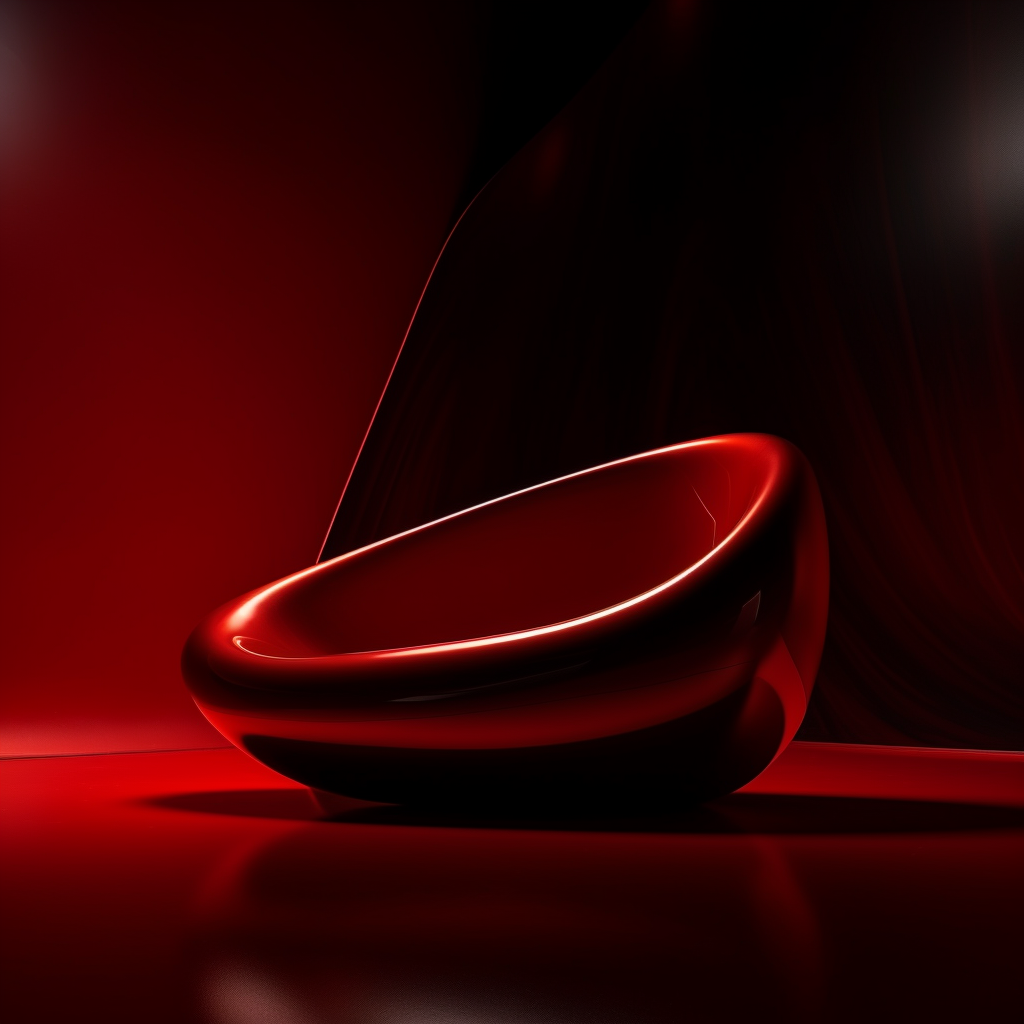

In [139]:
img

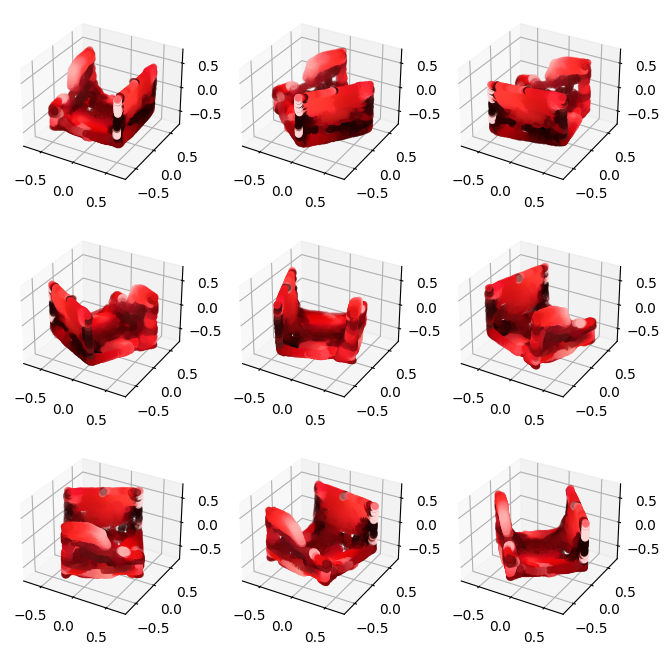

In [140]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [141]:
import plotly.graph_objects as go

In [142]:
fig_plotly = go.Figure(
        data=[
            go.Scatter3d(
                x=pc.coords[:,0], y=pc.coords[:,1], z=pc.coords[:,2], 
                mode='markers',
                marker=dict(
                  size=2,
                  color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(pc.channels["R"], pc.channels["G"], pc.channels["B"])],
              )
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        ),
    )

In [143]:
fig_plotly.show(renderer="colab")

In [144]:
from point_e.util.pc_to_mesh import marching_cubes_mesh

In [145]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

creating SDF model...
loading SDF model...


<All keys matched successfully>

In [146]:
import skimage.measure as measure

In [147]:
# Produce a mesh (with vertex colors)
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=32, # increase to 128 for resolution used in evals
    progress=True,
)

  0%|          | 0/8 [00:00<?, ?it/s]

In [148]:
from google.colab import files

In [149]:
# Write the mesh to a PLY file to import into some other program.
with open('mesh.ply', 'wb') as f:
    mesh.write_ply(f)

In [150]:
files.download("mesh.ply")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>